# panfetal nonproductive repertoiore 

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
import dandelion as ddl

In [2]:
sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
sb.set_palette('colorblind')

In [3]:
ct_order = ['DN(early)_T','DN(P)_T', 'DN(Q)_T', 'DP(P)_T', 'DP(Q)_T','ABT(ENTRY)', 
             'CD4+T', 'CD8+T', 'TREG','CYCLING_T','CD8AA','TYPE_3_INNATE_T', 'TYPE_1_INNATE_T','ILC2', 'ILC3','CYCLING_ILC','NK', 'CYCLING_NK',
             'PRE_PRO_B','B1']# celltypes with nonproductive TRB
ct_color_map = dict(zip(ct_order, np.array(sb.color_palette('tab20'))[range(len(ct_order))]))

In [4]:
# set working directory
%cd /lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/

/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript


In [5]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [6]:
# import utils (in github folder utils)
import sys
sys.path.append('/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/utils')
from _chenqu_utils import *

# Load data

In [7]:
# object loaded with abTCR, gdTCR, BCR data in 02_panfetal_load_VDJ
adata_source = sc.read('write/abTCR_110123_panfetal.h5ad')

### abTCR - filter samples that have been sequenced

In [8]:
meta_ab = pd.read_csv('metadata/abTCR_metadata_cleaned_24032022.csv')

In [9]:
adata = adata_source[adata_source.obs['file'].isin(meta_ab['GEX_id'])].copy() # only leave samples that have been abTCR-sequenced

### subset cells to celltypes with productive/nonproductive TRB, and cells with TRBJ

In [10]:
# utility function to setup the data to change all the entries to the first vdj call and remove entries with ',' i.e. inconfident calling
bdata = ddl.tl.setup_vdj_pseudobulk(adata, 
                                    subsetby='anno_lvl_2_final_clean', 
                                    groups = ct_order, 
                                    mode='abT',
                                    productive_vdj=False, 
                                    productive_vj=False,
                                    allowed_chain_status=None,
                                    check_vdj_mapping=['j_call'],
                                    check_vj_mapping=None,
                                   )
bdata

AnnData object with n_obs × n_vars = 58759 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'bbk', 'scvi_clusters', 'anno_lvl_2_LYMPHOID', 'anno_lvl_2_MYELOID', 'anno_lvl_2_MEM_PROGENITORS', 'leiden_150', 'anno_lvl_2_final_clean', 'has_contig', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'duplicate_count_abT_VDJ', 'duplicate_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ

In [11]:
# pseudobulk by donor, celltype
bulk_adata = ddl.tl.vdj_pseudobulk(bdata, obs_to_bulk = ['file','anno_lvl_2_final_clean'], obs_to_take = ['file','donor','anno_lvl_2_final_clean'], extract_cols=['j_call_abT_VDJ_main'])

/home/jovyan/dandelion/dandelion/tools/_trajectory.py:386: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [12]:
# remove pseudobulks that have < 10 cells
bulk_adata = bulk_adata[bulk_adata.obs['cell_count']>=10]

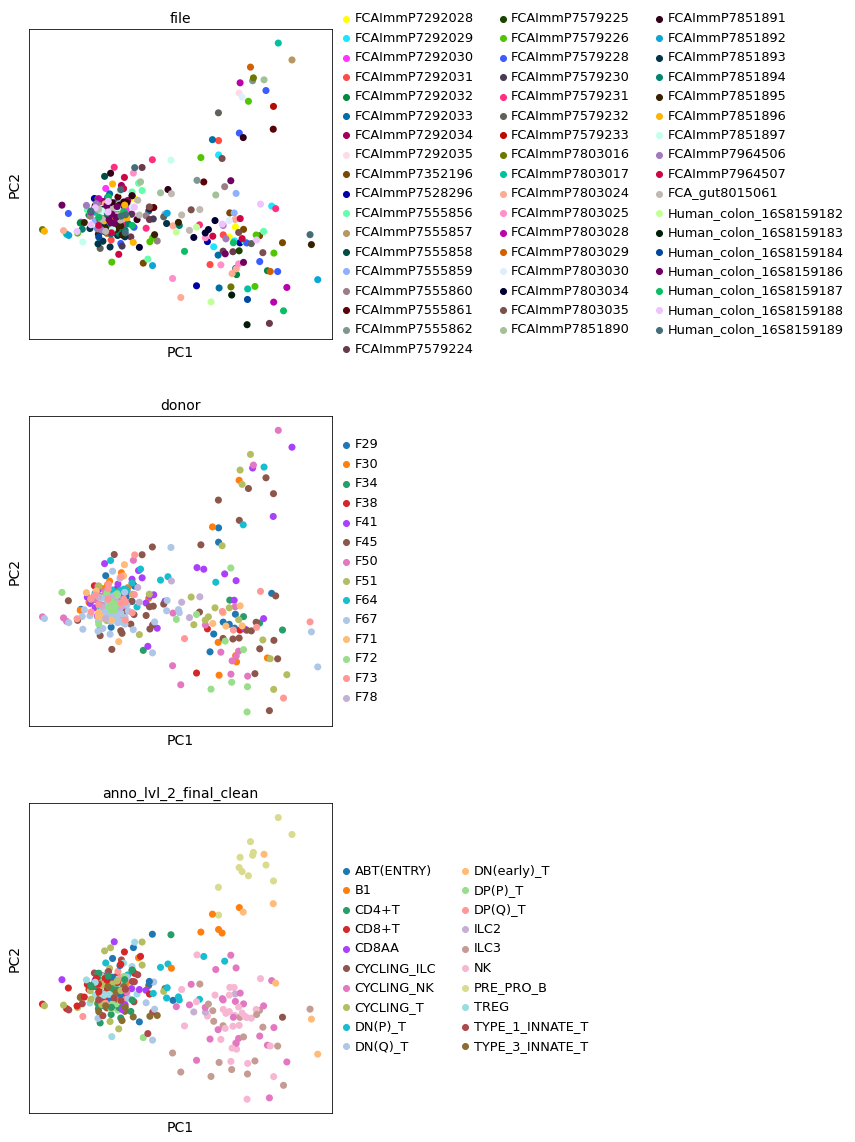

In [13]:
plt.rcParams["figure.figsize"] = [5,6]
sc.pp.pca(bulk_adata, random_state = 1712)
sc.pl.pca(bulk_adata, color=['file','donor','anno_lvl_2_final_clean'],ncols=1,size=200)

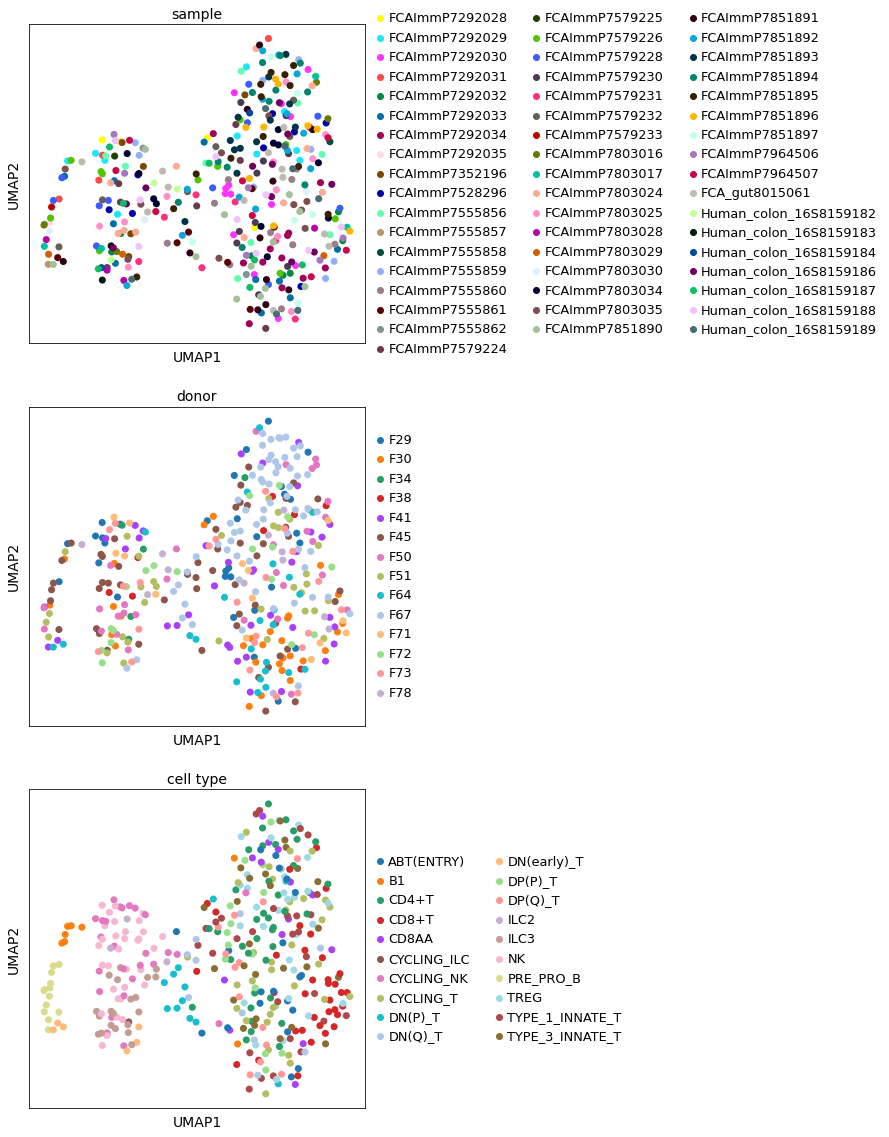

In [14]:
plt.rcParams["figure.figsize"] = [5,6]
sc.pp.neighbors(bulk_adata, random_state = 1712)
sc.tl.umap(bulk_adata, random_state = 1712)
sc.pl.umap(bulk_adata,  color=['file','donor','anno_lvl_2_final_clean'],title=['sample','donor','cell type'],ncols=1, 
           hspace=0.2, wspace=0.3,size=200,save='panfetal_TRBJ_pseudobulk.pdf')

### plot heatmap of TRBJ expression in different cell types

In [15]:
# pseudobulk by donor, celltype
bulk_adata_new = ddl.tl.vdj_pseudobulk(bdata, obs_to_bulk = ['anno_lvl_2_final_clean'], obs_to_take = ['anno_lvl_2_final_clean'], extract_cols=['j_call_abT_VDJ_main'])

/home/jovyan/dandelion/dandelion/tools/_trajectory.py:386: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [16]:
df_plot = pd.DataFrame(data = bulk_adata_new.X, columns = bulk_adata_new.var_names, index = bulk_adata_new.obs['anno_lvl_2_final_clean'])

In [17]:
df_plot = df_plot.loc[ct_order,:]

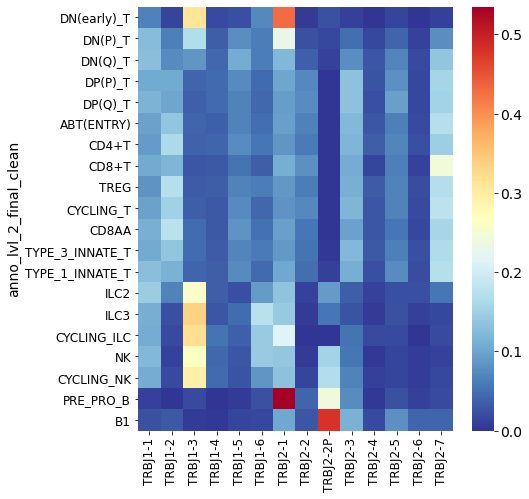

In [18]:
fig, ax = plt.subplots(figsize=(df_plot.shape[1]/2,df_plot.shape[0]*0.375))
#sb.set_theme()
uniform_data = df_plot
uniform_data=uniform_data.astype('float')
ax = sb.heatmap(uniform_data,cmap='RdYlBu_r')
_, xlabels = plt.xticks()
_, ylabels = plt.yticks()
ax.set_xticklabels(xlabels, size=12,rotation=90)
ax.set_yticklabels(ylabels, size=12,rotation=0)

plt.savefig(fig_path+'panfetal_TRBJ_heatmap.pdf',bbox_inches='tight');